
[INFO] Memproses exports_usd and imports_usd tahun 2000.png...
  -> ⚠️ Peringatan Kalibrasi (Exception): tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Peringatan: Kalibrasi otomatis gagal, menggunakan nilai fallback: Min=700000.0, Max=1700000.0.
  -> ✅ Sukses: Data untuk 2 variabel diekstrak dari exports_usd and imports_usd tahun 2000.png.

[INFO] Memproses exports_usd and imports_usd tahun 2001.png...
  -> ⚠️ Peringatan Kalibrasi (Exception): tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Peringatan: Kalibrasi otomatis gagal, menggunakan nilai fallback: Min=700000.0, Max=1700000.0.
  -> ✅ Sukses: Data untuk 2 variabel diekstrak dari exports_usd and imports_usd tahun 2001.png.

[INFO] Memproses exports_usd and imports_usd tahun 2002.png...
  -> ⚠️ Peringatan Kalibrasi (Exception): tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Per

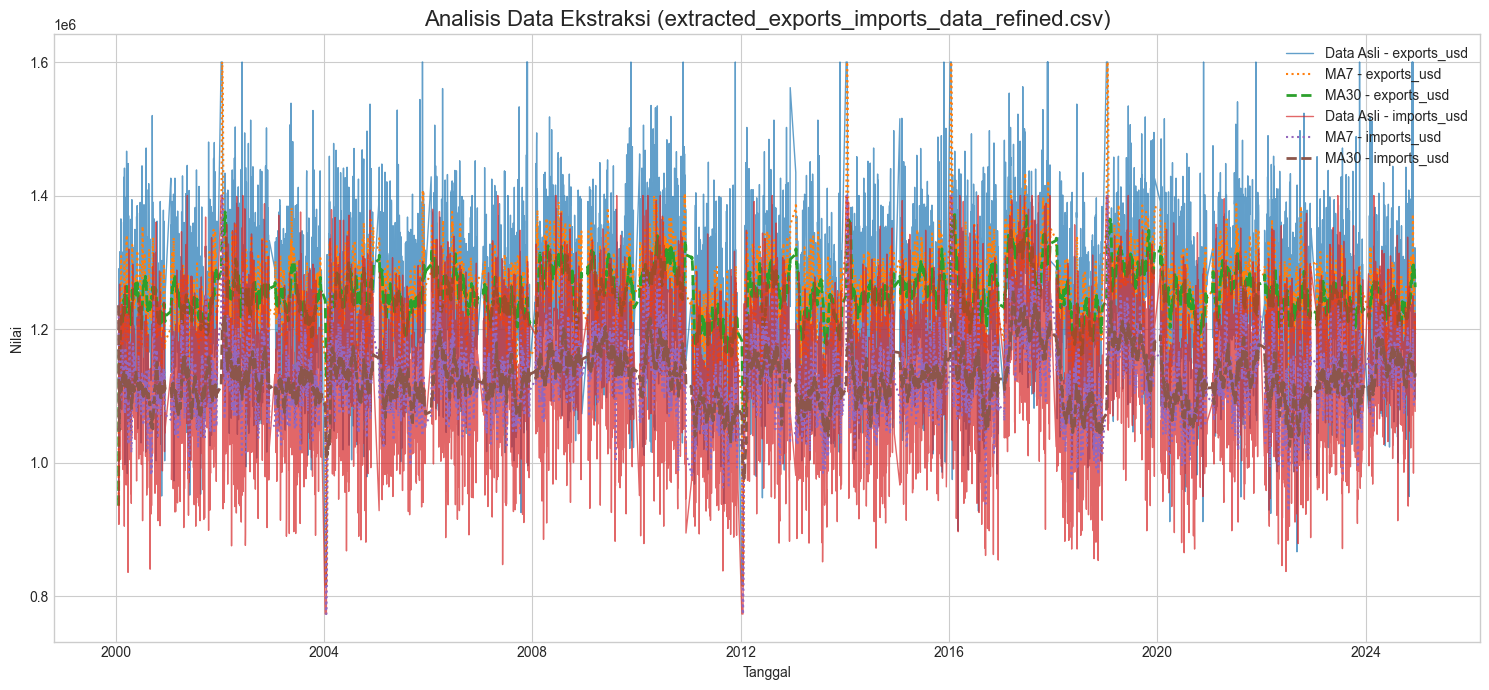


✅ SUKSES! 8236 baris data disimpan ke extracted_exports_imports_data_refined.csv


In [4]:
# ==============================================================================
# Script Ekstraksi Data Grafik v4.8 (Penyempurnaan untuk Garis Tumpang Tindih)
# Deskripsi:
#   Versi ini memuat perbaikan khusus untuk akurasi pembacaan
#   garis yang sangat berdekatan atau tumpang tindih.
#
# Kebutuhan: opencv-python, numpy, pandas, pytesseract, matplotlib
# ==============================================================================

import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta

# ==============================================================================
# 1. KONFIGURASI UTAMA (DISESUAIKAN SECARA SPESIFIK UNTUK GRAFIK INI)
# ==============================================================================
CONFIG = {
    # PATH DIPERBAIKI: Menggunakan 'raw string' untuk menghindari SyntaxError
    "folder_path": r"C:\Users\LENOVO\Downloads\statexplore\Data\C06\exports_usd and imports_usd",
    
    # Nama file CSV untuk menyimpan hasil
    "output_csv_file": "extracted_exports_imports_data_refined.csv",
    
    # Nilai fallback jika OCR gagal membaca sumbu Y (DIVERIFIKASI DARI GRAFIK)
    "fallback_y_min": 700000.0,
    "fallback_y_max": 1700000.0,
    
    # Tampilkan grafik hasil ekstraksi
    "visualize_output": True,
    
    # --- Konfigurasi Variabel (DISESUAIKAN) ---
    "variables": [
        {
            "name": "exports_usd",
            # Rentang warna HSV untuk garis BIRU (DIPERHALUS UNTUK AKURASI)
            "lower_color": np.array([85, 40, 40]),
            "upper_color": np.array([135, 255, 255]),
            # Batas nilai untuk variabel ini
            "clamp_min": 800000.0,
            "clamp_max": 1600000.0
        },
        {
            "name": "imports_usd",
            # Rentang warna HSV untuk garis ORANYE (DIPERHALUS UNTUK AKURASI)
            "lower_color": np.array([10, 100, 100]),
            "upper_color": np.array([25, 255, 255]),
            # Batas nilai untuk variabel ini
            "clamp_min": 750000.0,
            "clamp_max": 1400000.0
        }
    ]
}

# ==============================================================================
# 2. FUNGSI-FUNGSI BANTU & PREPROCESSING
# ==============================================================================
def is_leap(year: int) -> bool: return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

# Fungsi clean_mask disesuaikan untuk lebih agresif menghilangkan noise
def clean_mask(mask: np.ndarray) -> np.ndarray:
    kernel_open = np.ones((3, 3), np.uint8)
    kernel_close = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)
    return mask

# ==============================================================================
# 3. FUNGSI DETEKSI & KALIBRASI OTOMATIS
# ==============================================================================
def find_plot_area(image: np.ndarray) -> Optional[Tuple[np.ndarray, Dict[str, int]]]:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    
    min_area = image.shape[0] * image.shape[1] * 0.1
    max_area = image.shape[0] * image.shape[1] * 0.9
    
    filtered_contours = [c for c in contours if min_area < cv2.contourArea(c) < max_area]
    
    if not filtered_contours:
        largest_contour = max(contours, key=cv2.contourArea)
    else:
        largest_contour = max(filtered_contours, key=cv2.contourArea)
        
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    if w > image.shape[1] * 0.5 and h > image.shape[0] * 0.5:
        pad_y = int(h * 0.02)
        pad_x = int(w * 0.01)
        
        y_start = max(0, y - pad_y)
        y_end = min(image.shape[0], y + h + pad_y)
        x_start = max(0, x - pad_x)
        x_end = min(image.shape[1], x + w + pad_x)
        
        return image[y_start:y_end, x_start:x_end], {'x': x_start, 'y': y_start, 'w': x_end-x_start, 'h': y_end-y_start}
    return None

def calibrate_yaxis(image: np.ndarray, plot_coords: Dict[str, int]) -> Optional[Dict[str, float]]:
    try:
        yaxis_crop = image[plot_coords['y']:plot_coords['y']+plot_coords['h'], 0:plot_coords['x'] + 20]
        gray_yaxis = cv2.cvtColor(yaxis_crop, cv2.COLOR_BGR2GRAY)
        
        _, ocr_thresh = cv2.threshold(gray_yaxis, 180, 255, cv2.THRESH_BINARY_INV)
        
        ocr_text = pytesseract.image_to_string(ocr_thresh, config='--psm 6 -c tessedit_char_whitelist=0123456789.').strip()
        
        ocr_numbers = sorted([float(n) for n in re.findall(r'\b\d{2,7}\.?\d*\b', ocr_text) if 100000.0 < float(n) < 2000000.0], reverse=True)

        if len(ocr_numbers) < 2:
            print(f"  -> ⚠️ Peringatan Kalibrasi: Hanya {len(ocr_numbers)} angka terdeteksi dari sumbu Y. Teks OCR: '{ocr_text}'")
            return None

        plot_gray = cv2.cvtColor(image[plot_coords['y']:plot_coords['y']+plot_coords['h'], plot_coords['x']:plot_coords['x']+plot_coords['w']], cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(plot_gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=plot_coords['w']*0.8, maxLineGap=10)
        
        if lines is None:
            print("  -> ⚠️ Peringatan Kalibrasi: Tidak ada garis grid horizontal terdeteksi.")
            return None
        
        grid_y_coords = sorted(list(set([line[0][1] for line in lines if abs(line[0][1] - line[0][3]) < 5])))

        if len(grid_y_coords) < 2:
            print(f"  -> ⚠️ Peringatan Kalibrasi: Hanya {len(grid_y_coords)} garis grid horizontal terdeteksi.")
            return None

        top_line_y_pixel = grid_y_coords[0]
        bottom_line_y_pixel = grid_y_coords[-1]
        
        top_value = ocr_numbers[0]
        bottom_value = ocr_numbers[-1]

        pixel_span = bottom_line_y_pixel - top_line_y_pixel
        value_span = top_value - bottom_value

        if pixel_span == 0 or value_span == 0:
            print("  -> ⚠️ Peringatan Kalibrasi: Rentang pixel atau nilai tidak valid (nol).")
            return None

        pixels_per_value = pixel_span / value_span
        
        calibrated_y_max = top_value + (top_line_y_pixel / pixels_per_value)
        calibrated_y_min = calibrated_y_max - (plot_coords['h'] / pixels_per_value)
        
        print(f"  -> ✅ Kalibrasi Sumbu Y berhasil: Min={calibrated_y_min:.2f}, Max={calibrated_y_max:.2f}")
        return {'min': calibrated_y_min, 'max': calibrated_y_max}
    except Exception as e:
        print(f"  -> ⚠️ Peringatan Kalibrasi (Exception): {e}")
    return None

# ==============================================================================
# 4. FUNGSI EKSTRAKSI & PEMROSESAN
# ==============================================================================
def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    
    # Ambil semua piksel yang terdeteksi untuk setiap kolom X
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        
        if len(y_pixels) > 0:
            # Menggunakan np.median untuk stabilitas data, terutama di area noise
            y_pixel_center = int(np.median(y_pixels))
            
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            
            value = max(min(value, params['clamp_max']), params['clamp_min'])
            
            day_of_year = int((x_pixel / plot_w) * days_in_year)
            date = start_date + timedelta(days=day_of_year)
            
            extracted_data.append({
                "Date": date.strftime("%Y-%m-%d"), "Year": params['year'],
                "DayOfYear": day_of_year + 1,
                params['var_name']: round(value, 2)
            })
    return pd.DataFrame(extracted_data)

def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    proc_df = df.copy()
    proc_df['Date'] = pd.to_datetime(proc_df['Date'])
    proc_df = proc_df.sort_values(by='Date').drop_duplicates(subset=['Date'], keep='first').set_index('Date')
    
    if 'Year' in proc_df.columns: proc_df = proc_df.drop(columns=['Year', 'DayOfYear'])
    
    proc_df.interpolate(method='linear', limit_direction='both', inplace=True)
    proc_df.interpolate(method='time', inplace=True)
    
    proc_df.dropna(inplace=True)
    
    vars_to_analyze = [v['name'] for v in config.get('variables', [])]
    for var_name in vars_to_analyze:
        if var_name in proc_df.columns:
            proc_df[f'{var_name}_MA7'] = proc_df[var_name].rolling(window=7, min_periods=1).mean()
            proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30, min_periods=1).mean()
    return proc_df

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    title = f"Analisis Data Ekstraksi ({config['output_csv_file']})";
    plt.style.use('seaborn-v0_8-whitegrid');
    fig, ax = plt.subplots(figsize=(15, 7))
    
    vars_to_plot = [v['name'] for v in config.get('variables', [])]
    for var_name in vars_to_plot:
        if var_name in df.columns:
            ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7, linewidth=1)
            if f'{var_name}_MA7' in df.columns:
                ax.plot(df.index, df[f'{var_name}_MA7'], label=f'MA7 - {var_name}', linestyle=':', linewidth=1.5)
            if f'{var_name}_MA30' in df.columns:
                ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--', linewidth=2)
                
    ax.set_title(title, fontsize=16);
    ax.set_xlabel("Tanggal");
    ax.set_ylabel("Nilai");
    ax.legend();
    plt.tight_layout();
    plt.show()

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================
def main(config: Dict[str, Any]):
    if not os.path.isdir(config['folder_path']):
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'.")
        return
    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
    if not all_files:
        print(f"⚠️ PERINGATAN: Tidak ada file gambar (.png, .jpg) yang ditemukan di folder.")
        return
    all_results = []
    for filename in all_files:
        print(f"\n[INFO] Memproses {filename}...")
        full_path = os.path.join(config['folder_path'], filename)
        img = cv2.imread(full_path)
        if img is None:
            print(f"  -> ⚠️ Peringatan: Gagal membaca file {filename}, dilewati.")
            continue
        plot_info = find_plot_area(img)
        if not plot_info:
            print("  -> ⚠️ Peringatan: Area plot tidak terdeteksi, file dilewati.")
            continue
        plot_area, plot_coords = plot_info
        calibration = calibrate_yaxis(img, plot_coords)
        if calibration:
            y_min, y_max = calibration['min'], calibration['max']
        else:
            print(f"  -> ⚠️ Peringatan: Kalibrasi otomatis gagal, menggunakan nilai fallback: Min={config['fallback_y_min']}, Max={config['fallback_y_max']}.")
            y_min, y_max = config['fallback_y_min'], config['fallback_y_max']
        
        # Ekstrak tahun dari nama file atau judul gambar
        year_search = re.search(r'(\d{4})', filename)
        if not year_search:
            try:
                title_crop = img[0:int(img.shape[0]*0.1), 0:img.shape[1]]
                title_text = pytesseract.image_to_string(title_crop, config='--psm 3').strip()
                year_search_title = re.search(r'(\d{4})', title_text)
                if not year_search_title:
                     print("  -> ⚠️ Peringatan: Tahun tidak ditemukan di nama file atau judul, dilewati.")
                     continue
                year_from_file = int(year_search_title.group(1))
            except Exception as e:
                 print(f"  -> ⚠️ Peringatan: Gagal OCR judul ({e}), dilewati.")
                 continue
        else:
            year_from_file = int(year_search.group(1))
            
        hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
        variables_to_process = config.get('variables', [])
        year_dataframes = []
        for var_info in variables_to_process:
            mask = cv2.inRange(hsv, var_info['lower_color'], var_info['upper_color'])
            cleaned_mask = clean_mask(mask)
            series_params = {
                'year': year_from_file, 'y_min': y_min, 'y_max': y_max,
                'clamp_min': var_info['clamp_min'], 'clamp_max': var_info['clamp_max'],
                'var_name': var_info['name']
            }
            df_year_var = extract_series_from_mask(cleaned_mask, series_params)
            if not df_year_var.empty:
                year_dataframes.append(df_year_var)
        if year_dataframes:
            merged_df_year = year_dataframes[0]
            for i in range(1, len(year_dataframes)):
                merged_df_year = pd.merge(
                    merged_df_year,
                    year_dataframes[i],
                    on=['Date', 'Year', 'DayOfYear'],
                    how='outer'
                )
            all_results.append(merged_df_year)
            print(f"  -> ✅ Sukses: Data untuk {len(year_dataframes)} variabel diekstrak dari {filename}.")
    if not all_results:
        print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak.")
        return
    final_df = pd.concat(all_results, ignore_index=True)
    analyzed_df = post_process_data(final_df, config)
    if config.get('visualize_output', True) and not analyzed_df.empty:
        visualize_results(analyzed_df, config)
    analyzed_df.reset_index(inplace=True)
    analyzed_df.to_csv(config['output_csv_file'], index=False)
    print(f"\n✅ SUKSES! {len(analyzed_df)} baris data disimpan ke {config['output_csv_file']}")

# ==============================================================================
# 6. ENTRY POINT (Titik Awal Eksekusi Program)
# ==============================================================================
if __name__ == '__main__':
    # Baris di bawah ini mungkin diperlukan jika Tesseract tidak ada di PATH sistem Anda
    # Hapus tanda # dan sesuaikan path jika perlu.
    # pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    
    main(CONFIG)